In [65]:
using LinearAlgebra
using Plots
using Printf
using OffsetArrays
using Integrals
using StaticArrays

In [66]:
width = 1000
height = 400
fig_size = (width, height);

In [ ]:
# @enum FlaxMethod LaxFriedrichs LaxWendroff Godunov #Roe # HLL HLLC
@enum BoundaryCondition Reflecting Extrapolate # Periodic
@enum SlopeLimiter Minmod VanLeer SuperBee MC  Godunov LaxWendroff None 
# todo can  merge solvers + limiters into limiters as different limiters correspond to different methods

In [68]:
sv = @SVector [1,2]

2-element SVector{2, Int64} with indices SOneTo(2):
 1
 2

In [69]:
cv = convert(MArray, sv)
cv

2-element MVector{2, Int64} with indices SOneTo(2):
 1
 2

In [70]:
cv[1] = -1

-1

In [71]:
convert(SVector, cv)

2-element SVector{2, Int64} with indices SOneTo(2):
 -1
  2

In [72]:
A = [1 0; 0 1]
eigen(A)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 1.0
 1.0
vectors:
2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [73]:
0 < 1 ? 'a' : 'b'

'a': ASCII/Unicode U+0061 (category Ll: Letter, lowercase)

In [144]:
ϵ = 1e-20
ϵ / ϵ

1.0

In [ ]:
struct OutputData
    q::Vector{SVector}
    gcL::Vector{SVector}
    gcR::Vector{SVector}
    ngc::Int32
    t::Float64
    x::Vector{Float64}
end


#= todo 

Use a grid structure to store the state
auxiliarry data that would otherwise be computed multiple times
ie matrixes, eigenvalues etc

=#
struct Grid
    q::Vector{SVector}
end


function apply_boundary_condition!(q, bc, nbc; u_index=0)
    if bc == Reflecting
        for i in 1:nbc
            tmp = convert(MArray, q[i])
            tmp[u_index] = -tmp[u_index]
            q[1-i] = convert(SVector, tmp)

            tmp = convert(MArray, q[end  - nbc + 1 - i])
            tmp[u_index] = -tmp[u_index]
            q[end - nbc + i] = convert(SVector, tmp)

        end
        
    elseif bc == Extrapolate
        for i in 1:nbc
            q[1-i] = q[1]
            q[end-i+1] = q[end - i]
        end
    end
end


function rs(q, i, A::AbstractMatrix, dx, dt)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    λ, R = eigen(A)
    R_inv = inv(R)

    Ap = R * diagm(max.(λ, 0)) * R_inv
    Am = R * diagm(min.(λ, 0)) * R_inv


    return q[i] - dt/dx * (Ap * dqm + Am * dqp) 
end


function rs(q, i, A::Number, dx, dt)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    Ap = max(A, 0)
    Am = min(A, 0)

    return q[i] - dt/dx * (Ap * dqm + Am * dqp) 
end

function get1dLimit(q, i, limiter) 
    I = u < 0 ? i + 1 :  i - 1
    ϵ = 1e-20
    dqi = q[i] - q[i-1]
    dqI = q[I] - q[I-1]

    α = (dqI[1] + ϵ)/(dqi[1] + ϵ)
    l = limit(α, limiter)

    if isnan(l)
        @printf "a=%d  dqi=%d  dqI=%d  i=%d \n" α dqi[1] dqI[1] i 
    end
    return  l
end
    

function rs(q, i, u::Number, dx, dt, limiter)
    dqm = q[i] - q[i-1]
    dqp = q[i+1] - q[i]

    ν = u * dt / dx

    if u >= 0
        am = get1dLimit(q, i, limiter)
        ap = get1dLimit(q, i+1, limiter)
        return q[i] -ν * dqm - 0.5 * ν *(1-ν) * ( ap * dqp - am * dqm)
    else
        am = get1dLimit(q, i, limiter)
        ap = get1dLimit(q, i+1, limiter)
        return q[i] -ν * dqp + 0.5 * ν *(1+ν) * ( ap * dqp - am * dqm)
    end
end

function limit(θ, limiter::SlopeLimiter) 
    if limiter == Minmod
        return minmod(1, θ)
    elseif limiter == SuperBee
        return max(0, min(1, 2*θ), min(2, θ))
    elseif limiter == MC
        return max(0, min((1+θ)/2, 2, 2*θ) )
    elseif limiter == Godunov
        return 0
    elseif limiter == LaxWendroff
        return 1
    elseif limiter == Beamwarming
        return θ
    elseif limiter == Fromm
        return (1+θ)/2
    end
    return 0
end

# todo use CFL rather than dt 
# proper way to call functions instead of defining them twice for 1d
# use fluxes rather than methods? and use a single methdo combining them
function LaxWendroffStep(q, i, A, dx, dt)
    return q[i] - 0.5 * dt/dx * A * (q[i+1] - q[i-1]) + 0.5 * (dt/dx)^2 * A^2 * (q[i-1] - 2*q[i] + q[i+1]) 
end


# write a method that takes the method enum and return the right function
# then use that in the loops rather than if/switch statements
function evolve(q, i, A, dt, dx, method, limiter)
    if limiter != None
        return rs(q, i, A, dx, dt, limiter)
    end 
    if method == LaxFriedrichs
        return (q[i-1] + q[i+1])/2  - dt/dx * ( A * q[i]  - A*q[i-1]) # not tested
    elseif method == Godunov
       return rs(q, i, A, dx, dt)
    elseif method == LaxWendroff
        return LaxWendroffStep(q, i ,A, dx, dt)
    end
end





function minmod(a, b)
    if a*b < 0
        return 0
    elseif abs(a) < abs(b)
        return a
    else
        return b
    end
end



function solve(A, a, b, dx , dt, tmax, g_initial; limiter=None, method=Godunov, log_interval=0, boundary_condition=Extrapolate, u_index=0)
    
    # hardcoded boundary condition for now
    # 2 ghost cells front and back
    ngc = 2

    N = Int((b-a)/dx)+1

    ndim = length(g_initial(a))
    # initiliaze grid

        
    q0 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)
    q1 = OffsetArray( [@SVector zeros(ndim) for i in 1:(N+2*ngc)],  -ngc)

    @printf("N = %d\n", N)
    # improve later on

    for i in 1:N
        iv =  g_initial(a + (i-1)*dx)
        if isa(iv, Number)
            q0[i] = @SVector [iv]
        else
            q0[i] = iv
        end
    end


    x = collect(a:dx:b)
    τ = 0
    last_log = 0

    output = [OutputData(q0[1:N], q0[1-ngc:0], q0[N+1:N+ngc], ngc, τ, x)]

    # Linear constant coefficient problems for now
    while τ < tmax
        # boundary condition
        apply_boundary_condition!(q0, boundary_condition, ngc; u_index=u_index)

        for i in 1:N
            
            # reconstruction

            # evolution

            q1[i] = evolve(q0, i, A, dt, dx, method, limiter)
            # Averaging
            
            # todo check CFL condition

        end

        # log
        if log_interval > 0 && τ - last_log > log_interval
            push!(output, OutputData(q1[1:N], q1[1-ngc:0], q1[N+1:N+ngc], ngc, τ, x))
            last_log = τ
        end

        # swap states
        q0, q1 = q1, q0
   
        τ += dt
    end

    push!(output, OutputData(q1[1:N], q0[1-ngc:0], q0[N+1:N+ngc], ngc, τ, x))
    return output
end




solve (generic function with 1 method)

In [146]:
g_ind(x, a, b) = if (x > a && x < b) 1 else 0 end

g_initial(x) = exp(-200*(x-0.3)^2)  + g_ind(x, 0.6, 0.8)

g_initial (generic function with 1 method)

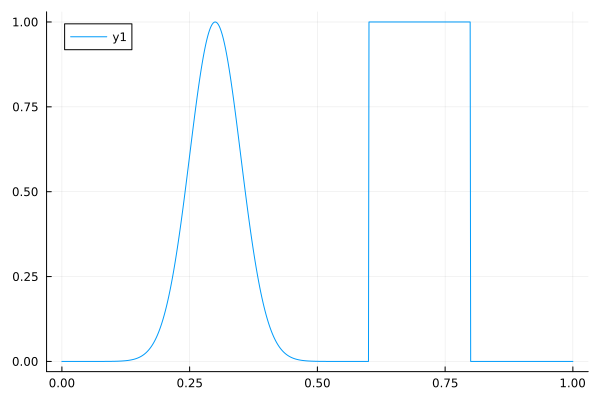

In [147]:
x = 0:0.001:1
plot(x, g_initial.(x))

In [164]:
u = 1
a = 0
b = 2
dx = 0.01
dt = 0.005

sol = solve(u, a, b, dx , dt, 1.2, g_initial; limiter=MC, method=Godunov, log_interval=dt, boundary_condition=Reflecting, u_index=1);

N = 201


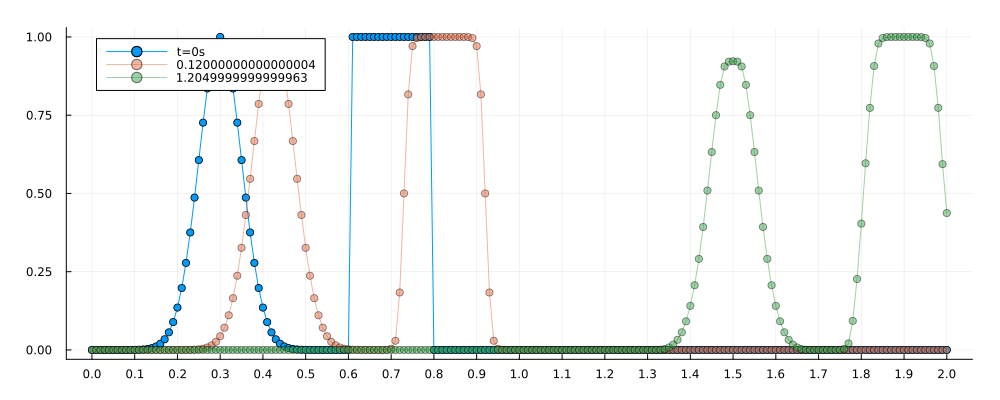

In [165]:
using Plots.PlotMeasures

n = Int(round(length(sol) / 2))
n = 20


plot(sol[1].x, first.(sol[1].q), marker=:circle, label="t=0s", size=fig_size, margin=5mm, xticks=0:0.1:2)
plot!(sol[n].x, first.(sol[n].q), marker=:circle, label="$(sol[n].t)", opacity=0.5)
plot!(sol[end].x, first.(sol[end].q), marker=:circle, label="$(sol[end].t)", opacity=0.5)

In [33]:
sol[117].q 

201-element Vector{SVector}:
 [1.522997974471263e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 ⋮
 [1.0000000000002869]
 [1.0000000000000615]
 [1.0000000000000127]
 [1.0000000000000024]
 [1.0000000000000004]
 [1.0]
 [1.0]
 [1.0]
 [1.0]

In [51]:
append!(sol[117].q, sol[117].gcR)

203-element Vector{SVector}:
 [1.522997974471263e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 ⋮
 [1.0000000000000127]
 [1.0000000000000024]
 [1.0000000000000004]
 [1.0]
 [1.0]
 [1.0]
 [1.0]
 [-1.0]
 [-1.0]

In [58]:
q = sol[117].q
i = 201
A = 1
a
dqm = q[i] - q[i-1]
dqp = q[i+1] - q[i]

Ap = max(A, 0)
Am = min(A, 0)

q[i] - dt/dx * (Ap * dqm + Am * dqp) 

1-element SVector{1, Float64} with indices SOneTo(1):
 1.0

In [62]:
Am

0

In [52]:
sol[117].q  

203-element Vector{SVector}:
 [1.522997974471263e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 [1.5229979744712626e-8]
 [-1.5229979744712626e-8]
 ⋮
 [1.0000000000000127]
 [1.0000000000000024]
 [1.0000000000000004]
 [1.0]
 [1.0]
 [1.0]
 [1.0]
 [-1.0]
 [-1.0]

In [53]:
rs(sol[117].q, 201, 1, 0.1, 0.1)

1-element SVector{1, Float64} with indices SOneTo(1):
 1.0

In [37]:
sol[117].gcR

2-element Vector{SVector}:
 [-1.0]
 [-1.0]

N = 201


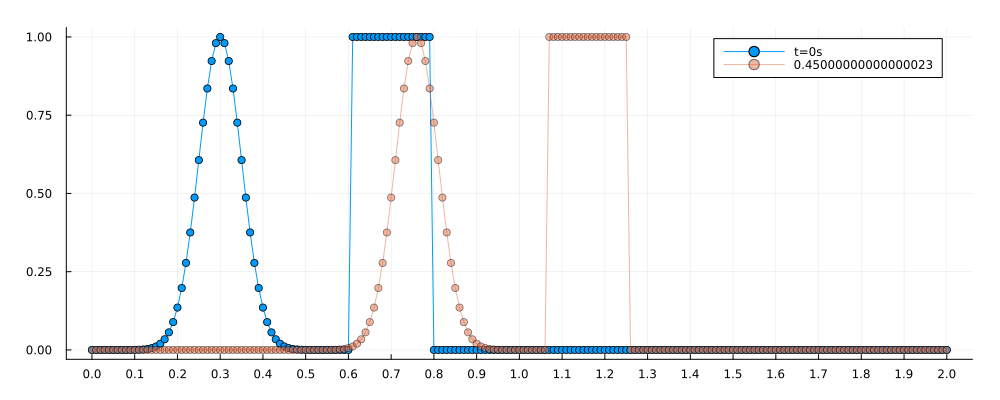

In [35]:
CFL = 1/2 

u_cfl = 1
a_cfl = 0
b_cfl = 2
dx_cfl = 0.01
dt_cfl = 0.01


n = 40
t = n * dt_cfl 

sol_cfl = solve(u_cfl, a_cfl, b_cfl, dx_cfl , dt_cfl, 4, g_initial; method=Godunov, log_interval=dt_cfl)

plot(sol_cfl[n].x, first.(sol_cfl[1].q), marker=:circle, label="t=0s", size=(1000, 400), margin=5mm, xticks=0:0.1:2)
plot!(sol_cfl[n].x, first.(sol_cfl[n].q), marker=:circle, label="$(sol_cfl[n].t)", opacity=0.5)

In [66]:
p_0(x) = exp(-80*x^2)/2 + g_ind(x, -0.3, -0.1)
u_0(x) = 0 
q_0(x) = [p_0(x), u_0(x)]

q_0 (generic function with 1 method)

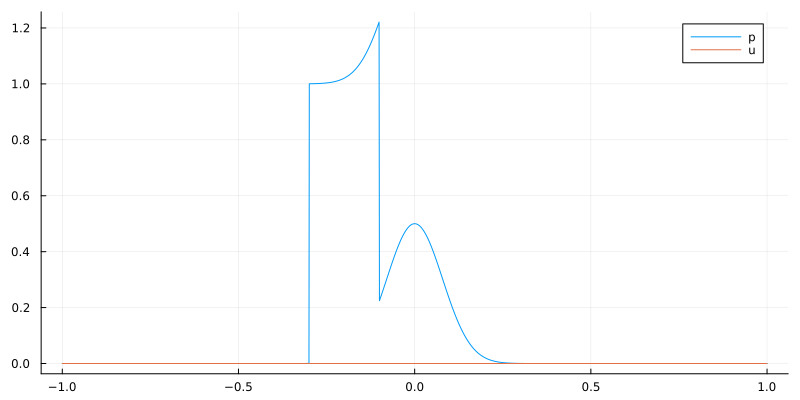

In [67]:
x = -1:0.001:1
plot(x, p_0.(x), label="p", size=(800, 400))
plot!(x, u_0.(x), label="u")

In [71]:
po = 1
Ko = 0.25

A =    [0 Ko; 1/po 0]
dx = 0.01 
dt = 0.01
tmax = 4
method = Godunov



sol_acc = solve(A, -1, 1, dx , dt, tmax, q_0; method=Godunov, log_interval=0.1, boundary_condition=Reflecting, u_index=2)


N = 201


40-element Vector{OutputData}:
 OutputData(SVector[[9.024256939227076e-36, 0.0], [4.434128423968185e-35, 0.0], [2.1441559560061996e-34, 0.0], [1.020365491633119e-33, 0.0], [4.778663420419642e-33, 0.0], [2.2024619332469147e-32, 0.0], [9.989912114251356e-32, 0.0], [4.459295091268569e-31, 0.0], [1.958944111113027e-30, 0.0], [8.468942168123125e-30, 0.0]  …  [8.468942168123005e-30, 0.0], [1.9589441111130548e-30, 0.0], [4.459295091268569e-31, 0.0], [9.989912114251356e-32, 0.0], [2.2024619332469147e-32, 0.0], [4.778663420419642e-33, 0.0], [1.020365491633119e-33, 0.0], [2.1441559560061996e-34, 0.0], [4.434128423968185e-35, 0.0], [9.024256939227076e-36, 0.0]], SVector[[0.0, 0.0], [0.0, 0.0]], SVector[[0.0, 0.0], [0.0, 0.0]], 2, 0.0, [-1.0, -0.99, -0.98, -0.97, -0.96, -0.95, -0.94, -0.93, -0.92, -0.91  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
 OutputData(SVector[[1.2214700540142111e-30, -1.5163214042370756e-30], [4.21745550189019e-30, -8.221391540574458e-30], [1.72600091145

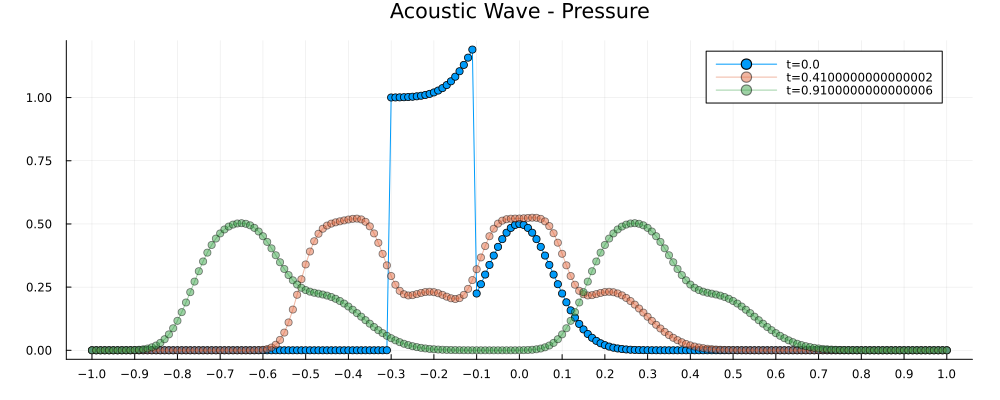

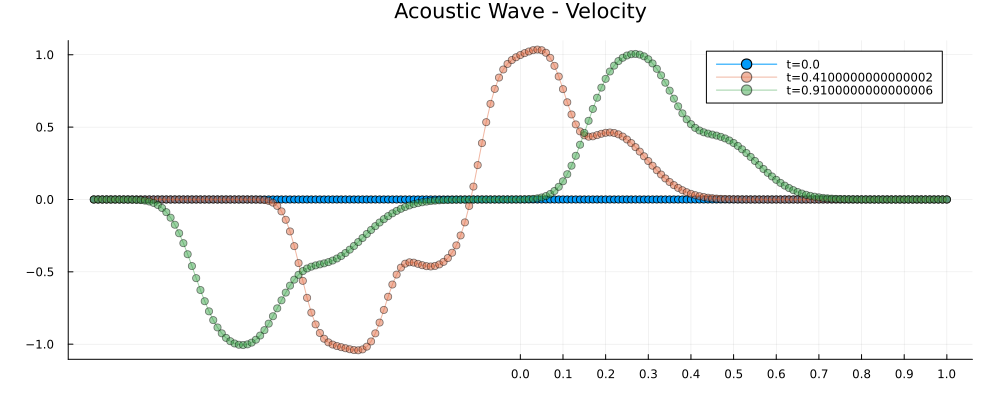

In [90]:
fig1 = plot(sol_acc[1].x, first.(sol_acc[1].q), marker=:circle, label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=-1:0.1:1, title="Acoustic Wave - Pressure")
plot!(sol_acc[5].x, first.(sol_acc[5].q), marker=:circle, label="t=$(sol_acc[5].t)", opacity=0.5)
plot!(sol_acc[10].x, first.(sol_acc[10].q), marker=:circle, label="t=$(sol_acc[10].t)", opacity=0.5)

display(fig1)

fig2 = plot(sol_acc[1].x, getindex.(sol_acc[1].q, 2), marker=:circle, label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Velocity")
plot!(sol_acc[5].x, getindex.(sol_acc[5].q, 2), marker=:circle, label="t=$(sol_acc[5].t)", opacity=0.5)
plot!(sol_acc[10].x, getindex.(sol_acc[10].q, 2), marker=:circle, label="t=$(sol_acc[10].t)", opacity=0.5)
display(fig2)

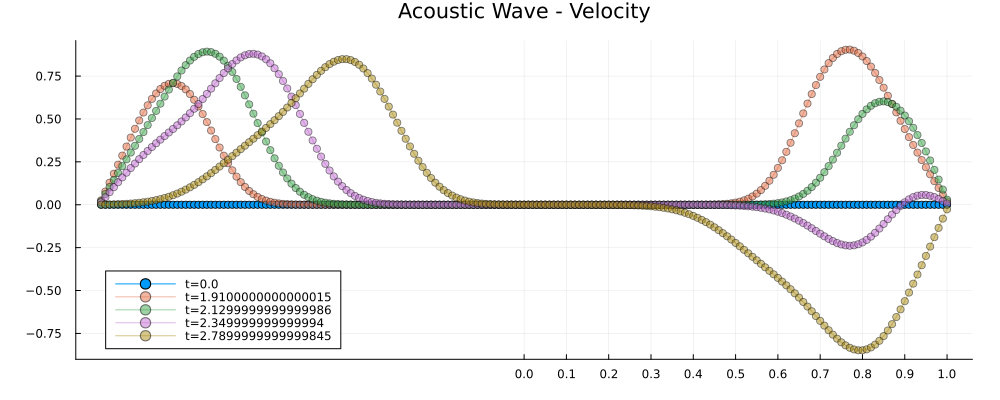

In [85]:
fig = plot(sol_acc[1].x, getindex.(sol_acc[1].q, 2), marker=:circle, label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Velocity")


for N in [20, 22, 24, 28]
    plot!(sol_acc[N].x, getindex.(sol_acc[N].q, 2), marker=:circle, label="t=$(sol_acc[N].t)", opacity=0.5)
end

display(fig)

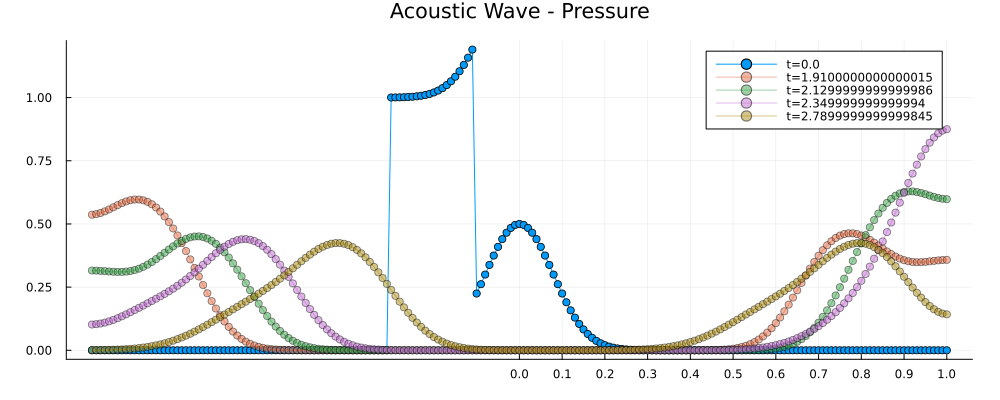

In [87]:
fig = plot(sol_acc[1].x, getindex.(sol_acc[1].q, 1), marker=:circle, label="t=$(sol_acc[1].t)", size=fig_size, margin=5mm, xticks=0:0.1:2,  title="Acoustic Wave - Pressure")


for N in [20, 22, 24, 28]
    plot!(sol_acc[N].x, getindex.(sol_acc[N].q, 1), marker=:circle, label="t=$(sol_acc[N].t)", opacity=0.5)
end

display(fig)

In [131]:
size(q_0(0))

(2,)

In [132]:
ndims(q_0(0))

1